# Apple Stock Analysis
-------
This is a large project which analyzes various aspects of Apple's (AAPL) stock over the last 5 years.

In [51]:
import csv
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import NumeralTickFormatter, LabelSet, Label
from bokeh.layouts import gridplot

output_notebook()

# Import index file from Yahoo Finance
filename = 'aapl.csv'
fileobj = open(filename, 'r')
readerobj = csv.reader(fileobj)
data = []
for r in readerobj:
    data.append(r)
fileobj.close()
aapl = np.asarray(data) # convert to NumPy array

Loading BokehJS ...

-------
## Data Functions

In [52]:
def launch_close(ind, d):
    """
    Find the closing stock value for a given date.

    The function accepts a date as a string as input, then finds and 
    returns the closing value in the corresponding column. 

    Positional Input Parameters:
        ind : NumPy Array
            Array of index values.
        d : String
            Date as string.
    """
    condition = np.where(ind == d)[0]
    close = ind[condition,4]
    return close

def launch_week(ind, d):
    """
    Find the closing stock value for a given date.

    The function accepts a date as a string as input, then finds the closing
    value in the corresponding column. Then it gets the three days before,
    and three days after, then creates an array with all 7 values to create
    a weeks worth of closing values.

    Positional Input Parameters:
        ind : NumPy Array
            Array of index values.
        d : String
            Date as string.
    """
    condition = np.where(ind == d)[0]
    close = ind[condition,4]
    c_1 = ind[condition-1,4]
    c_2 = ind[condition-2,4]
    c_3 = ind[condition-3,4]
    c1 = ind[condition+1,4]
    c2 = ind[condition+2,4]
    c3 = ind[condition+3,4]
    w = np.array([c_3,c_2,c_1,close,c1,c2,c3])
    week = np.reshape(w,(7))
    return week.astype('float')

def launch_change(ind, d,ip):
    """
    Find the change in closing price for the week of a given date.

    The function uses the launch_week function and creates a float array
    with the given index and date. It then subtracts the minimum value in that
    week from the maximum value to find the overall change in price for
    the week. It then prints the difference with the given iPhone model name.

    Positional Input Parameters:
        ind : NumPy Array
            Array of index values.
        d : String
            Date as string.
        ip : String
            iPhone name as string.
    """
    week = np.array([launch_week(ind,d)]).astype(np.float)
    dayof = week[0,3]
    wmin = np.amin(week)
    wmax = np.amax(week)
    change = wmax - wmin
    return ('Price Statistics for Week of ' + str(ip) + 
        ' Launch'
        + '\n\tHigh:\t'+str(round(wmax,3)) 
        + '\t\tDay of Launch:\t' + str(round(dayof,3))
        + '\n\tLow:\t' + str(round(wmin,3))
        + '\t\tPrice Change:\t' + str(round(change,3)))

def num_days_big_percent_chg(index, percent):
    """
    Calculate the number of days there was a significant
    percentage change in the index value, based on magnitude.

    The function calculates and returns the total number of 
    trading days where the percent change in the stock index since 
    the prior day is greater than the value of the magnitude percent.

    Positional Input Parameters:
        index : NumPy Array
            Array of values. 
        percent : Float Value
            Decimal value of corresponding percentage.
    """
    num_bin = 0
    sub1 = np.ravel(index)
    sub = np.asarray(sub1, dtype ='float64')
    change = ((sub[1:] - sub[0:-1])/sub[0:-1])*100
    net = np.where(abs(change) > percent, 1, 0)
    num_bin = np.count_nonzero(net)
    return num_bin

def num_days_list(index,yr): # Function to create bins for NDBPC (above)
    """
    Create bins for the num_days_big_percent_chg of a given year. Then
    print the days for each percentage threshold (1 to 5%).

    Positional Input Parameters:
        index : NumPy Array
            Array of index values.
        yr : String
            Year as string.
    """
    n1 = num_days_big_percent_chg(index, 1.0)
    n2 = num_days_big_percent_chg(index, 2.0)
    n3 = num_days_big_percent_chg(index, 3.0)
    n4 = num_days_big_percent_chg(index, 4.0)
    n5 = num_days_big_percent_chg(index, 5.0)
    print('Days in ' + str(yr) + ' w/ Significant % Change')
    return ('1% : \t(' + str(n1) + ')\t2% : \t(' + str(n2) + 
        ')\t3% : \t(' + str(n3) + ')\t4% : \t(' + str(n4) + 
        ')\t5% : \t(' + str(n5) + ')\n')

def oneyear(ind,start,end):
    """
    Creates an array of dates from the start and end inputs. The for-loop
    goes over each date in the array, and if that date exists in the input 
    index, it will take the corresponding closing price value using the 
    launch_close function. These values are appended to a list and returned
    as an array.

    Positional Input Parameters:
        ind : NumPy Array
            Array of values.
        start : String
            Date as string.
        end : String
            Date as string.
    """
    net = []
    times = np.arange(np.datetime64(start), np.datetime64(end))
    index = times.astype(str)
    for i in index:
        if i in ind:
            close = launch_close(ind,i)
            net.append(close)
    year = np.asarray(net, dtype='float64')
    
    return year
    
def yr_moving_avg(ind):
    """
    Calculate the three-day simple moving average 
    for the index values in an array. Input is the array created by
    a call to the oneyear function, to extract a specified year from
    the 5-year data set.

    The function accepts an index array as input and 
    returns a three-day simple moving average for each
    trading day.

    Positional Input Parameters:
        ind : NumPy Array
            Array of values.
    """
    arr = np.array(ind)
    output = arr[2:]
    output += ind[1:-1]
    output += ind[0:-2]
    return output / 3.0
    
def yr_range(ind,start,end,yr):
    """
    Calculates statistical data for a given year in the index.
    
    The function takes the index, start date, and end date parameters and 
    passes them into the oneyear function. From that array, it takes the 
    minimum and maximum, then the difference between the two. It also takes
    the average of the values in the array.
    
    It prints these values in an easy-to-read format in the terminal.

    Positional Input Parameters:
        ind : NumPy Array
            Array of values.
        start : String
            Date as string.
        end : String
            Date as string.
        yr : String
            Year as string.
    """
    year = oneyear(ind,start,end)
    low = np.amin(year)
    high = np.amax(year)
    diff = high - low
    avg = np.average(year)
    return ('Annual Statistics for ' + str(yr) + '\n'
    '\tHighest Stock Value: \t' + str(round(high,3))
    + '\tDifference in Value: \t' + str(round(diff,3)) + '\n' 
    '\tLowest Stock Value: \t' + str(round(low,3))
    + '\tAverage of Values: \t' + str(round(avg,3)))

def ihigh(ind, d):
    # Finds the stock price high for a given date
    # Created for the diff function
    condition = np.where(ind == d)[0]
    close = ind[condition,2]
    return close

def ilow(ind,d):
    # Finds the stock price low for a given date
    # Created for the diff function
    condition = np.where(ind == d)[0]
    close = ind[condition,3]
    return close

def diff(ind,start,end):
    """
    Calculates the difference between the daily high and low for the year.
    
    Creates an array of dates from the start and end inputs. The for-loop
    goes over each date in the array. If that date exists in the input 
    index, it will take the corresponding high price value using the 
    ihigh function, then the corresponding low price value using the 
    ilow function and create arrays of both values.
    
    The difference is then taken between the highs and lows arrays for each day,
    then a single array of these values is returned.

    Positional Input Parameters:
        ind : NumPy Array
            Array of values.
        start : String
            Date as string.
        end : String
            Date as string.
    """
    highs = []
    lows = []
    times = np.arange(np.datetime64(start), np.datetime64(end))
    index = times.astype(str)
    for i in index:
        if i in ind:
            high = ihigh(ind,i)
            low = ilow(ind,i)
            highs.append(high)
            lows.append(low)
    h = np.asarray(highs, dtype='float64')
    l = np.asarray(lows, dtype='float64')  
    diff = h - l
    return diff

def plot_diff(diffs, yrnum, c): # Function to plot year of high/low difference
    days = np.arange(len(diffs))
    plt.plot(days, diffs, str(c) + '-')
    plt.title('The Daily Change in Stock Value for Year '+str(yrnum))
    plt.xlabel('Number of Days')
    plt.ylabel('Change in Value [USD]')
    plt.show()

def plot_yr_ma(yr,yrnum,name): # Function to plot moving average
    y = yr.flatten()
    td = np.arange(len(y))
    ma = yr_moving_avg(y)
    # Excludes the first two days in days and index
    plt.plot(td[2:], y[2:], 'g', label= "Index Value")
    plt.plot(td[2:], ma, 'b-', label="Moving Average")
    plt.title(str(name) + ' 3-Day Moving Average vs Index Value')
    plt.xlabel('Trading Days in '+str(yrnum))
    plt.ylabel('Stock Index Value [USD]')
    plt.legend(loc='best')
    plt.show()

-----
# Yearly Statistics and Graphs

## 2014

Days in 2014 w/ Significant % Change
1% : 	(98)	2% : 	(20)	3% : 	(7)	4% : 	(3)	5% : 	(2)

Annual Statistics for 2014
	Highest Stock Value: 	119.0	Difference in Value: 	47.603
	Lowest Stock Value: 	71.397	Average of Values: 	92.192


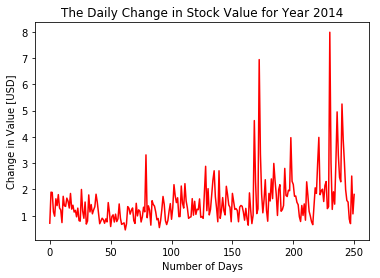

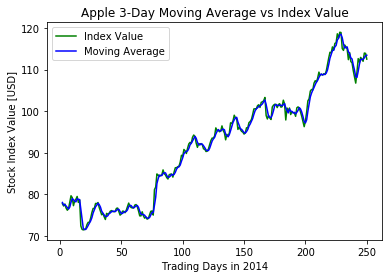

In [53]:
y2014 = oneyear(aapl,'2014-01-01','2014-12-31')
print(num_days_list(y2014,'2014'))
yr2014 = yr_range(aapl,'2014-01-01','2014-12-31','2014')
print(yr2014)

d2014 = diff(aapl,'2014-01-01','2014-12-31')
plt.figure('2014 Change')
plot_diff(d2014,'2014','r')
plt.figure('Moving Average 2014')
plot_yr_ma(y2014,'2014','Apple')

## 2015

Days in 2015 w/ Significant % Change
1% : 	(116)	2% : 	(52)	3% : 	(20)	4% : 	(8)	5% : 	(4)

Annual Statistics for 2015
	Highest Stock Value: 	133.0	Difference in Value: 	29.88
	Lowest Stock Value: 	103.12	Average of Values: 	120.099


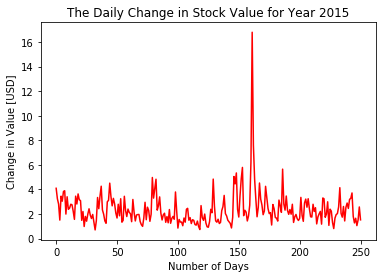

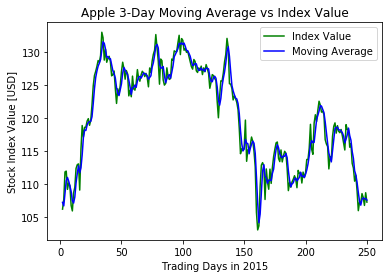

In [54]:
y2015 = oneyear(aapl,'2015-01-01','2015-12-31')
print(num_days_list(y2015,'2015'))
yr2015 = yr_range(aapl,'2015-01-01','2015-12-31','2015')
print(yr2015)

d2015 = diff(aapl,'2015-01-01','2015-12-31')
plt.figure('2015 Change')
plot_diff(d2015,'2015','r')
plt.figure('Moving Average 2015')
plot_yr_ma(y2015,'2015','Apple')

## 2016

Days in 2016 w/ Significant % Change
1% : 	(89)	2% : 	(35)	3% : 	(11)	4% : 	(5)	5% : 	(4)

Annual Statistics for 2016
	Highest Stock Value: 	118.25	Difference in Value: 	27.91
	Lowest Stock Value: 	90.34	Average of Values: 	104.604


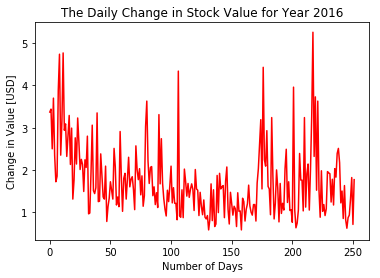

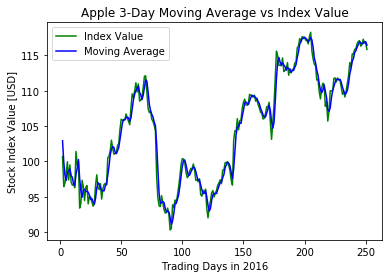

In [55]:
y2016 = oneyear(aapl,'2016-01-01','2016-12-31')
print(num_days_list(y2016,'2016'))
yr2016 = yr_range(aapl,'2016-01-01','2016-12-31','2016')
print(yr2016)

d2016 = diff(aapl,'2016-01-01','2016-12-31')
plt.figure('2016 Change')
plot_diff(d2016,'2016','r')
plt.figure('Moving Average 2016')
plot_yr_ma(y2016,'2016','Apple')

## 2017

Days in 2017 w/ Significant % Change
1% : 	(68)	2% : 	(17)	3% : 	(6)	4% : 	(2)	5% : 	(1)

Annual Statistics for 2017
	Highest Stock Value: 	176.42	Difference in Value: 	60.4
	Lowest Stock Value: 	116.02	Average of Values: 	150.551


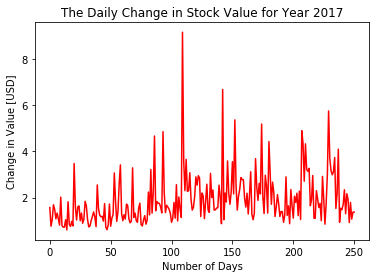

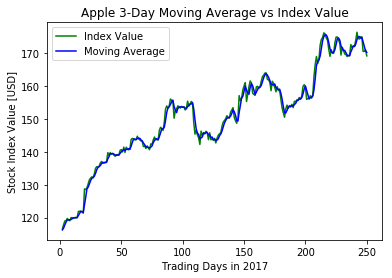

In [56]:
y2017 = oneyear(aapl,'2017-01-01','2017-12-31')
print(num_days_list(y2017,'2017'))
yr2017 = yr_range(aapl,'2017-01-01','2017-12-31','2017')
print(yr2017)

d2017 = diff(aapl,'2017-01-01','2017-12-31')
plt.figure('2017 Change')
plot_diff(d2017,'2017','r')
plt.figure('Moving Average 2017')
plot_yr_ma(y2017,'2017','Apple')

## 2018

Days in 2018 w/ Significant % Change
1% : 	(92)	2% : 	(37)	3% : 	(15)	4% : 	(10)	5% : 	(3)

Annual Statistics for 2018
	Highest Stock Value: 	232.07	Difference in Value: 	76.92
	Lowest Stock Value: 	155.15	Average of Values: 	191.613


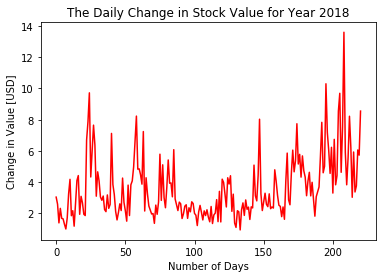

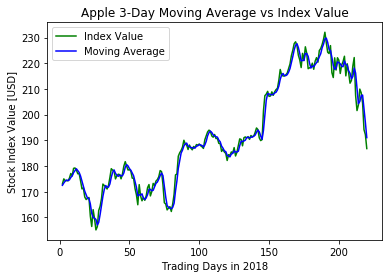

In [57]:
y2018 = oneyear(aapl,'2018-01-01','2018-12-31')
print(num_days_list(y2018,'2018'))
yr2018 = yr_range(aapl,'2018-01-01','2018-12-31','2018')
print(yr2018)

d2018 = diff(aapl,'2018-01-01','2018-12-31')
plt.figure('2018 Change')
plot_diff(d2018,'2018','r')
plt.figure('Moving Average 2018')
plot_yr_ma(y2018,'2018','Apple')

-----
# Product Launches

In [58]:
# Dates of Apple Special Events (iPhone Announcements)
ip_6 = '2014-09-09'
ip_6s = '2015-09-09'
ip_7 = '2016-09-07'
ip_8 = '2017-09-12'
ip_Xs = '2018-09-12'

print(launch_change(aapl,ip_6,'iPhone 6'))
print(launch_change(aapl,ip_6s,'iPhone 6s'))
print(launch_change(aapl,ip_7,'iPhone 7'))
print(launch_change(aapl,ip_8,'iPhone 8'))
print(launch_change(aapl,ip_Xs,'iPhone Xs')+ '\n')

lw_ip_6 = launch_week(aapl,ip_6)
lw_ip_6s = launch_week(aapl,ip_6s)
lw_ip_7 = launch_week(aapl,ip_7)
lw_ip_8 = launch_week(aapl,ip_8)
lw_ip_Xs = launch_week(aapl,ip_Xs)

days = np.arange(1,8)

p1 = figure(plot_width=300, plot_height=300, x_range=(1, 7), y_range=(97, 103))
p1.yaxis[0].formatter = NumeralTickFormatter(format="$0")
p2 = figure(plot_width=300, plot_height=300, x_range=(1, 7), y_range=(108, 116))
p2.yaxis[0].formatter = NumeralTickFormatter(format="$0")
p3 = figure(plot_width=300, plot_height=300, x_range=(1, 7), y_range=(102, 109))
p3.yaxis[0].formatter = NumeralTickFormatter(format="$0")
p4 = figure(plot_width=300, plot_height=300, x_range=(1, 7), y_range=(157, 162))
p4.yaxis[0].formatter = NumeralTickFormatter(format="$0")
p5 = figure(plot_width=300, plot_height=300, x_range=(1, 7), y_range=(217, 227))
p5.yaxis[0].formatter = NumeralTickFormatter(format="$0")

p1.line(days, lw_ip_6, line_width=2)
p2.line(days, lw_ip_6s, line_width=2)
p3.line(days, lw_ip_7, line_width=2)
p4.line(days, lw_ip_8, line_width=2)
p5.line(days, lw_ip_Xs, line_width=2)

grid = gridplot([p1,p2,p3,p4,p5], ncols=3)

show(grid)

Price Statistics for Week of iPhone 6 Launch
	High:	101.66		Day of Launch:	97.99
	Low:	97.99		Price Change:	3.67
Price Statistics for Week of iPhone 6s Launch
	High:	115.31		Day of Launch:	110.15
	Low:	109.27		Price Change:	6.04
Price Statistics for Week of iPhone 7 Launch
	High:	108.36		Day of Launch:	108.36
	Low:	103.13		Price Change:	5.23
Price Statistics for Week of iPhone 8 Launch
	High:	161.5		Day of Launch:	160.86
	Low:	158.28		Price Change:	3.22
Price Statistics for Week of iPhone Xs Launch
	High:	226.41		Day of Launch:	221.07
	Low:	217.88		Price Change:	8.53



-----
# Overall Stock Performance

In [59]:
sub = np.ravel(aapl[1:,4:5]).astype('float')
days = np.arange(len(sub))

p = figure(title = 'Apple Closing Values',
           plot_width=900, plot_height=400, x_range=(0,1260), y_range=(70, 240))
p.line(days, sub, line_width=2)
p.toolbar.logo = None
p.toolbar_location = None
p.xaxis[0].axis_label = 'Trading Days [between 11/14/2013 and 11/14/2018]'
p.yaxis[0].axis_label = 'Stock Value [USD]'
p.yaxis[0].formatter = NumeralTickFormatter(format="$0")

mytext = Label(x=125, y=70, text='Min: $71.397')
mytext2 = Label(x=1050, y=225, text='Max: $232.07')

p.add_layout(mytext)
p.add_layout(mytext2)

show(p)

-------
Data retrieved from Yahoo Finance.